In [1]:
pip install torch transformers accelerate scikit-learn pandas numpy matplotlib cupy-cuda13x

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import linalg
import numpy as np
import scipy
import cupy
import matplotlib.pyplot as plt

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

# Create device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


PyTorch version: 2.8.0+cu128
CUDA available: True
Using device: cuda


In [4]:
def gen_svd_bic_gaussian(A, S, U, Vt):
    rows, cols = tuple(A.shape)
    n = rows * cols
    Ak = torch.zeros_like(A)
    for k in range(1, S.shape[0]):
        Akk = torch.outer(U[:, k-1], S[k-1] * Vt[k-1, :])
        Ak = Ak + Akk
        Ares = (A - Ak).flatten()
        sigma, mu = torch.std_mean(Ares)
        t = torch.sum((Ares-mu)**2).item()
        mu, sigma = mu.item(), sigma.item()
        llh = -t / (2*(sigma**2)) - (n*np.log(2*np.pi*(sigma**2))/2)
        p = k * (rows + cols + 1)
        pterm = p * np.log(n)
        llhterm = -2*llh
        bic = pterm + llhterm
        yield (bic, pterm, llhterm)


In [5]:
def matrix_with_rank(k, rows, cols, scale=100):
    A = torch.randn(rows, cols, device=device, dtype=torch.float32)
    U, S, Vt = torch.linalg.svd(A, full_matrices=False)
    for j in range(k, S.shape[0]):
        S[j] /= scale
    return U @ torch.diag(S) @ Vt

In [6]:
def plot_residuals(ks, A, S, U, Vt):
    nk = len(ks)
    fig, axs = plt.subplots(nk, 1, figsize=(8, nk*3))
    axs = list(axs)
    xmin, xmax = -1e-3, +1e-3
    ymax = 0
    for ax, k in zip(axs, ks):
        Ak = U[:, :k] @ torch.diag(S[:k]) @ Vt[:k, :]
        Ares = (A - Ak).flatten().cpu().numpy()
        densities, edges = np.histogram(Ares, bins=50, density=True)
        ymax = max(ymax, np.max(densities))
        xmin = min(xmin, np.min(edges))
        xmax = max(xmax, np.max(edges))
        widths = np.diff(edges)
        ax.bar(edges[:-1], densities, width=widths, edgecolor='black')
        ax.set_xlabel('Residual')
        ax.set_ylabel('Density')
        ax.set_title(f'Residuals for k={k}')
    for ax in axs:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(0, 1.1*ymax)
    plt.tight_layout()
    plt.show()

In [7]:
def plot_svd(S, bicterms):
    S = np.array(S)
    bic = np.array([x[0] for x in bicterms])
    pterm = np.array([x[1] for x in bicterms])
    llhterm = np.array([x[2] for x in bicterms])

    # Plot singular values and cumulative energy
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 9))

    # Singular values
    ax1.semilogy(np.arange(1, 1+S.shape[0]),S)
    ax1.set_title('Singular Values')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Singular Value')
    ax1.grid(True)

    # BIC
    rankBIC = 1+bic.argmin()
    x = np.arange(1, 1+bic.shape[0])
    ax2.plot(x,bic)
    ax2.plot(x,pterm)
    ax2.plot(x,llhterm)
    ax2.set_title('BIC')
    ax2.set_xlabel('Number of Singular Values')
    ax2.set_ylabel('BIC')
    ax2.grid(True)
    ax2.axvline(x=rankBIC, color='k', linestyle='--', label=f'BIC Rank = {rankBIC}')
    ax2.legend()

    # Cumulative energy
    energy = S**2
    cumulative_energy = np.cumsum(energy) / np.sum(energy)
    rank90 = 1+np.argmax(cumulative_energy >= 0.9)

    ax3.plot(np.arange(1, 1+cumulative_energy.shape[0]),cumulative_energy)
    ax3.set_title('Cumulative Energy')
    ax3.set_xlabel('Number of Singular Values')
    ax3.set_ylabel('Fraction of Total Energy')
    ax3.grid(True)
    ax3.axhline(y=0.9, color='r', linestyle='--', label='90% Energy')
    ax3.axvline(x=rank90, color='r', linestyle='--', label=f'90% Rank = {rank90}')
    ax3.axvline(x=rankBIC, color='k', linestyle='--', label=f'BIC Rank = {rankBIC}')
    ax3.legend()


    plt.tight_layout()
    plt.show()


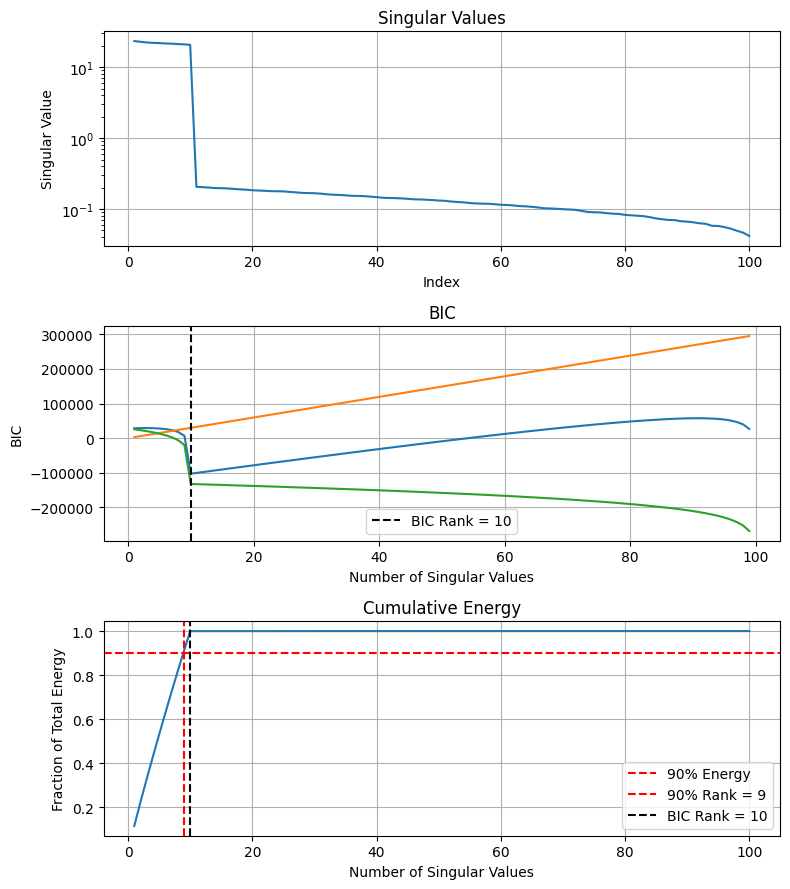

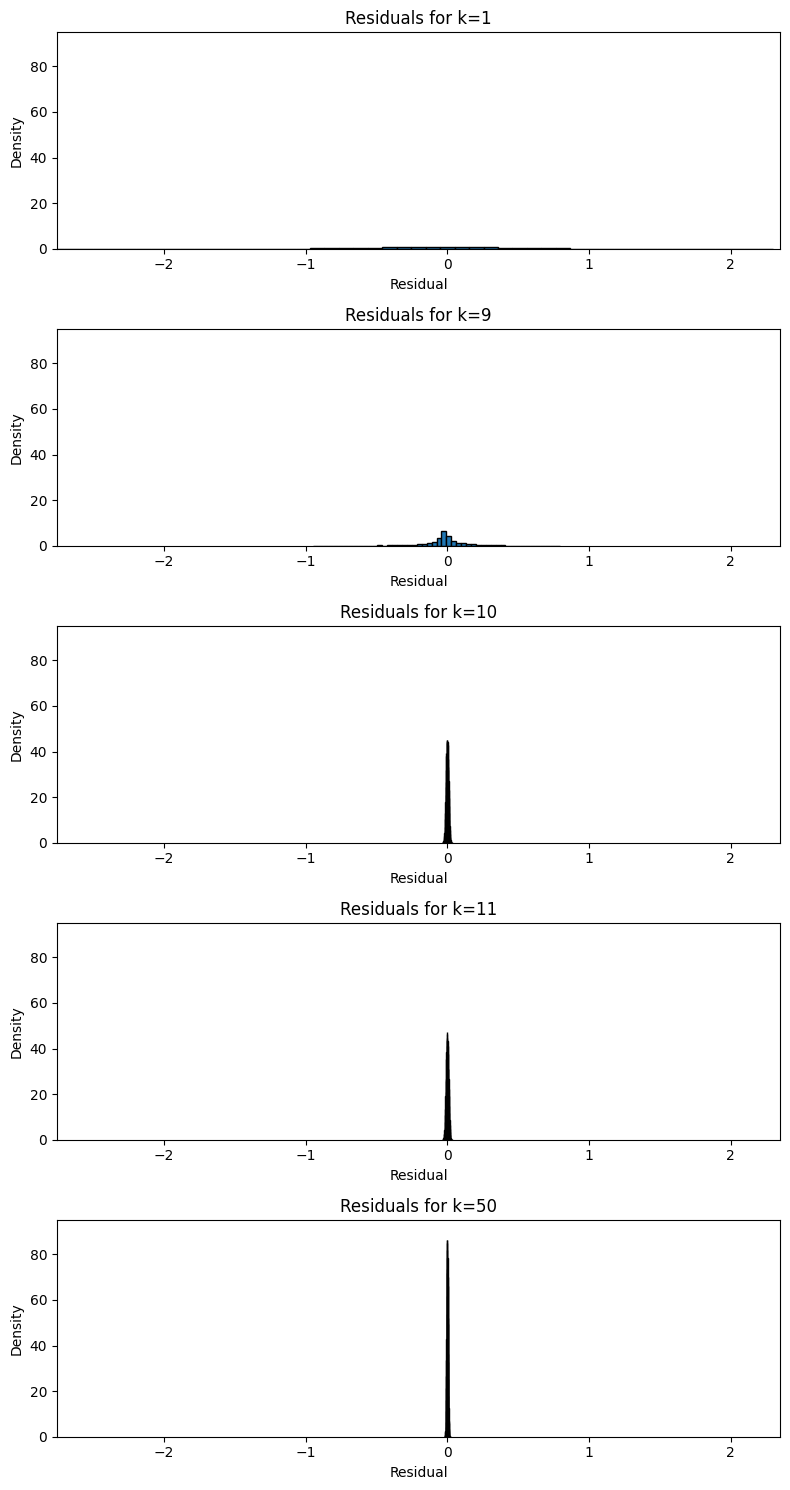

In [8]:
X10 = matrix_with_rank(10, 200, 100, scale=100)
Ux10, Sx10, Vtx10 = torch.linalg.svd(X10, full_matrices=False)
bic10 = list(gen_svd_bic_gaussian(X10, Sx10, Ux10, Vtx10))
plot_svd(Sx10.cpu().numpy(), bic10)
plot_residuals([1, 9, 10, 11, 50], X10, Sx10, Ux10, Vtx10)

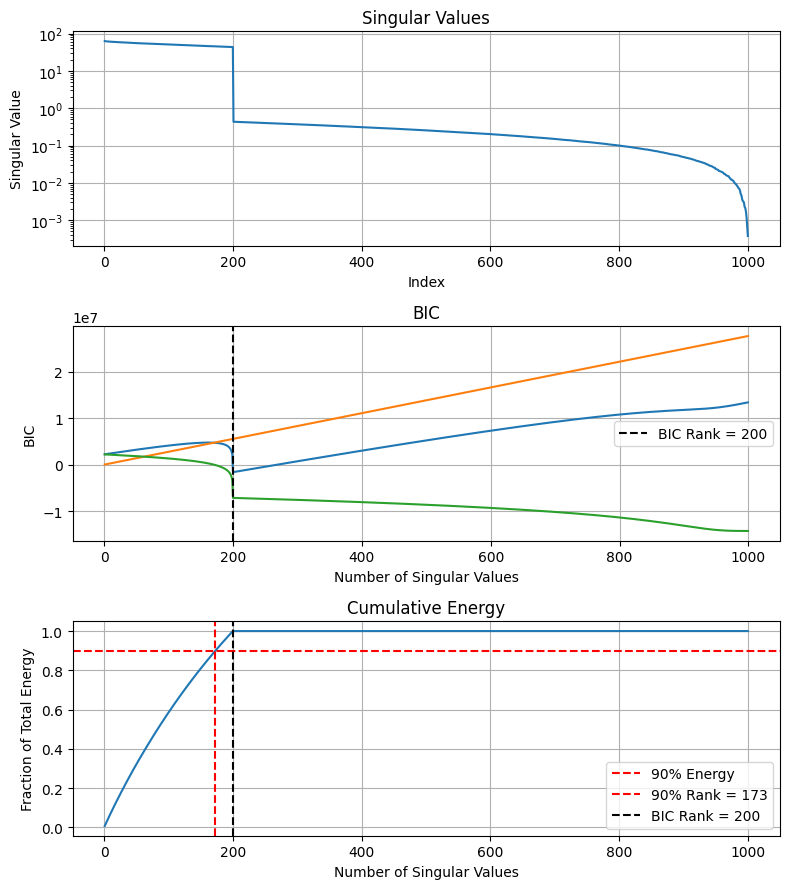

In [9]:
X = matrix_with_rank(200, 1000, 1000, scale=100)
Ux, Sx, Vtx = torch.linalg.svd(X, full_matrices=False)
bic = list(gen_svd_bic_gaussian(X, Sx, Ux, Vtx))
plot_svd(Sx.cpu().numpy(), bic)
#plot_residuals([1, 49, 50, 51, 80], X, Sx, Ux, Vtx)


In [10]:
from transformers import AutoModelForCausalLM
model_path = "ibm-granite/granite-3b-code-base"
#model_path = "meta-llama/Llama-3.2-1B"
#model_path = "unsloth/Llama-3.2-1B"
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="cpu",
    )
model.eval()

/home/eje/git/mdl-matrix-rank/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(49152, 2560, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
          (o_proj): Linear(in_features=2560, out_features=2560, bias=True)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2560, out_features=10240, bias=True)
          (up_proj): Linear(in_features=2560, out_features=10240, bias=True)
          (down_proj): Linear(in_features=10240, out_features=2560, bias=True)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((2560,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((2560,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((2560,), eps=1e-05)
    (

In [11]:
def gen_model_matrices(model, name_filter):
    for name, param in model.named_parameters():
        if not name.endswith(f"{name_filter}.weight"): continue
        yield param

In [12]:
q_proj = list(gen_model_matrices(model, "q_proj"))
k_proj = list(gen_model_matrices(model, "k_proj"))
v_proj = list(gen_model_matrices(model, "v_proj"))


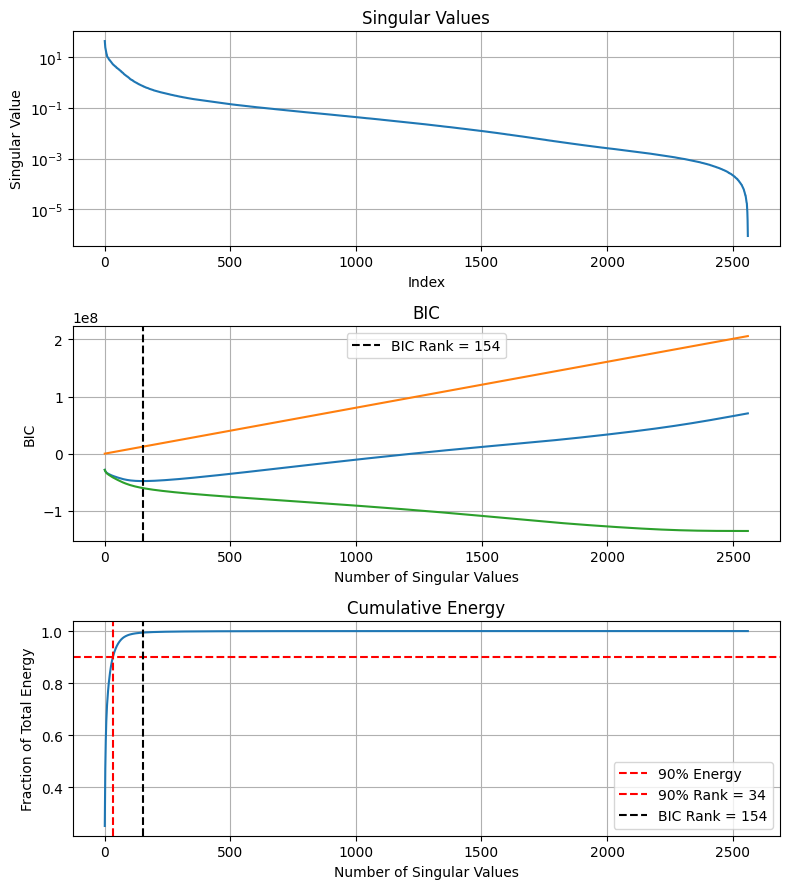

In [13]:
X = k_proj[0].detach().to("cuda:0")
U, S, Vt = torch.linalg.svd(X, full_matrices=False)
bic = list(gen_svd_bic_gaussian(X, S, U, Vt))
plot_svd(S.cpu().numpy(), bic)
#plot_residuals([1, 49, 50, 51, 80], X, S, U, Vt)
